In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

font = {'family': 'helvetica', 'size' :20}
plt.rc('font', **font)

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t, u, layers):
        
        # boundary conditions
        
        # data
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([0.0], requires_grad=True).to(device)
        #self.lambda_3 = torch.tensor([10.0], requires_grad=True).to(device)
        # self.lambda_4 = torch.tensor([10.0], requires_grad=True).to(device)
        # self.lambda_5 = torch.tensor([10.0], requires_grad=True).to(device)
        # self.lambda_6 = torch.tensor([10.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        #self.lambda_3 = torch.nn.Parameter(self.lambda_3)
        # self.lambda_4 = torch.nn.Parameter(self.lambda_4)
        # self.lambda_5 = torch.nn.Parameter(self.lambda_5)
        # self.lambda_6 = torch.nn.Parameter(self.lambda_6)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        #self.dnn.register_parameter('lambda_3', self.lambda_3)
        # self.dnn.register_parameter('lambda_4', self.lambda_4)
        # self.dnn.register_parameter('lambda_5', self.lambda_5)
        # self.dnn.register_parameter('lambda_6', self.lambda_6)
                
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1     
        lambda_2 = self.lambda_2
        #lambda_3 = self.lambda_3
        # lambda_4 = self.lambda_4     
        # lambda_5 = self.lambda_5
        # lambda_6 = self.lambda_6
                
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + (lambda_1 * t + (1 +lambda_2*t**2)/(1 + 1*t+ 1*t**3))*u - (t**3+2*t+(t**2)*(1+lambda_2*t**2)/(1+t+t**3))
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.t)
        f_pred = self.net_f(self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        # self.optimizer.zero_grad()
        # loss.backward()
        
        # self.iter += 1
        # if self.iter % 100 == 0:
        #     print(
        #         'Loss: %e, l1: %.5f, l2: %.5f' % 
        #         (
        #             loss.item(), 
        #             self.lambda_1.item(),
        #             self.lambda_2.item()
        #             #self.lambda_3.item()
        #         )
        #     )
        return loss
    
    def train(self, nIter):
        It = []
        Loss = []
        Lambda_1 = []
        Lambda_2 = []
        #Lambda_3 = []
        # Lambda_4 = []
        # Lambda_5 = []
        # Lambda_6 = []
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.t)
            f_pred = self.net_f(self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(),
                        self.lambda_2.item()
                        #self.lambda_3.item(),
                        # self.lambda_4.item(),
                        # self.lambda_5.item(),
                        # self.lambda_6.item()
                    )
                )
                It.append(epoch)
                Loss.append(loss.item())
                Lambda_1.append(self.lambda_1.item())
                Lambda_2.append(self.lambda_2.item())
                #Lambda_3.append(self.lambda_3.item())
                # Lambda_4.append(self.lambda_4.item())
                # Lambda_5.append(self.lambda_5.item())
                # Lambda_6.append(self.lambda_6.item())
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        return (It,Loss, Lambda_1, Lambda_2)
    
    def predict(self, t):
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
t_b = np.array([0.0])
u_b = np.array([1.0])

t = np.linspace(0,1,100)

N_u = 50
exat_u = np.exp(-t**2 / 2)/(1+t+t**3) + t**2

idx = np.random.choice(t.shape[0], N_u, replace=False)
t_f = t[idx]
u_f = exat_u[idx]

t_data = np.concatenate([t_b,t_f]).reshape(51,1)
u_data = np.concatenate([u_b,u_f]).reshape(51,1)


It: 0, Loss: 3.306e+00, Lambda_1: 0.001, Lambda_2: -0.001
It: 100, Loss: 1.001e+00, Lambda_1: 0.123, Lambda_2: -0.043
It: 200, Loss: 7.639e-01, Lambda_1: 0.221, Lambda_2: -0.001
It: 300, Loss: 6.659e-01, Lambda_1: 0.297, Lambda_2: 0.037
It: 400, Loss: 5.843e-01, Lambda_1: 0.367, Lambda_2: 0.072
It: 500, Loss: 5.125e-01, Lambda_1: 0.433, Lambda_2: 0.106
It: 600, Loss: 4.480e-01, Lambda_1: 0.495, Lambda_2: 0.138
It: 700, Loss: 3.884e-01, Lambda_1: 0.553, Lambda_2: 0.166
It: 800, Loss: 3.308e-01, Lambda_1: 0.607, Lambda_2: 0.192
It: 900, Loss: 2.722e-01, Lambda_1: 0.656, Lambda_2: 0.214
It: 1000, Loss: 2.082e-01, Lambda_1: 0.701, Lambda_2: 0.233
It: 1100, Loss: 1.356e-01, Lambda_1: 0.740, Lambda_2: 0.250
It: 1200, Loss: 6.912e-02, Lambda_1: 0.771, Lambda_2: 0.264
It: 1300, Loss: 2.915e-02, Lambda_1: 0.793, Lambda_2: 0.276
It: 1400, Loss: 1.424e-02, Lambda_1: 0.808, Lambda_2: 0.286
It: 1500, Loss: 1.031e-02, Lambda_1: 0.819, Lambda_2: 0.296
It: 1600, Loss: 9.033e-03, Lambda_1: 0.829, Lambd

KeyboardInterrupt: 

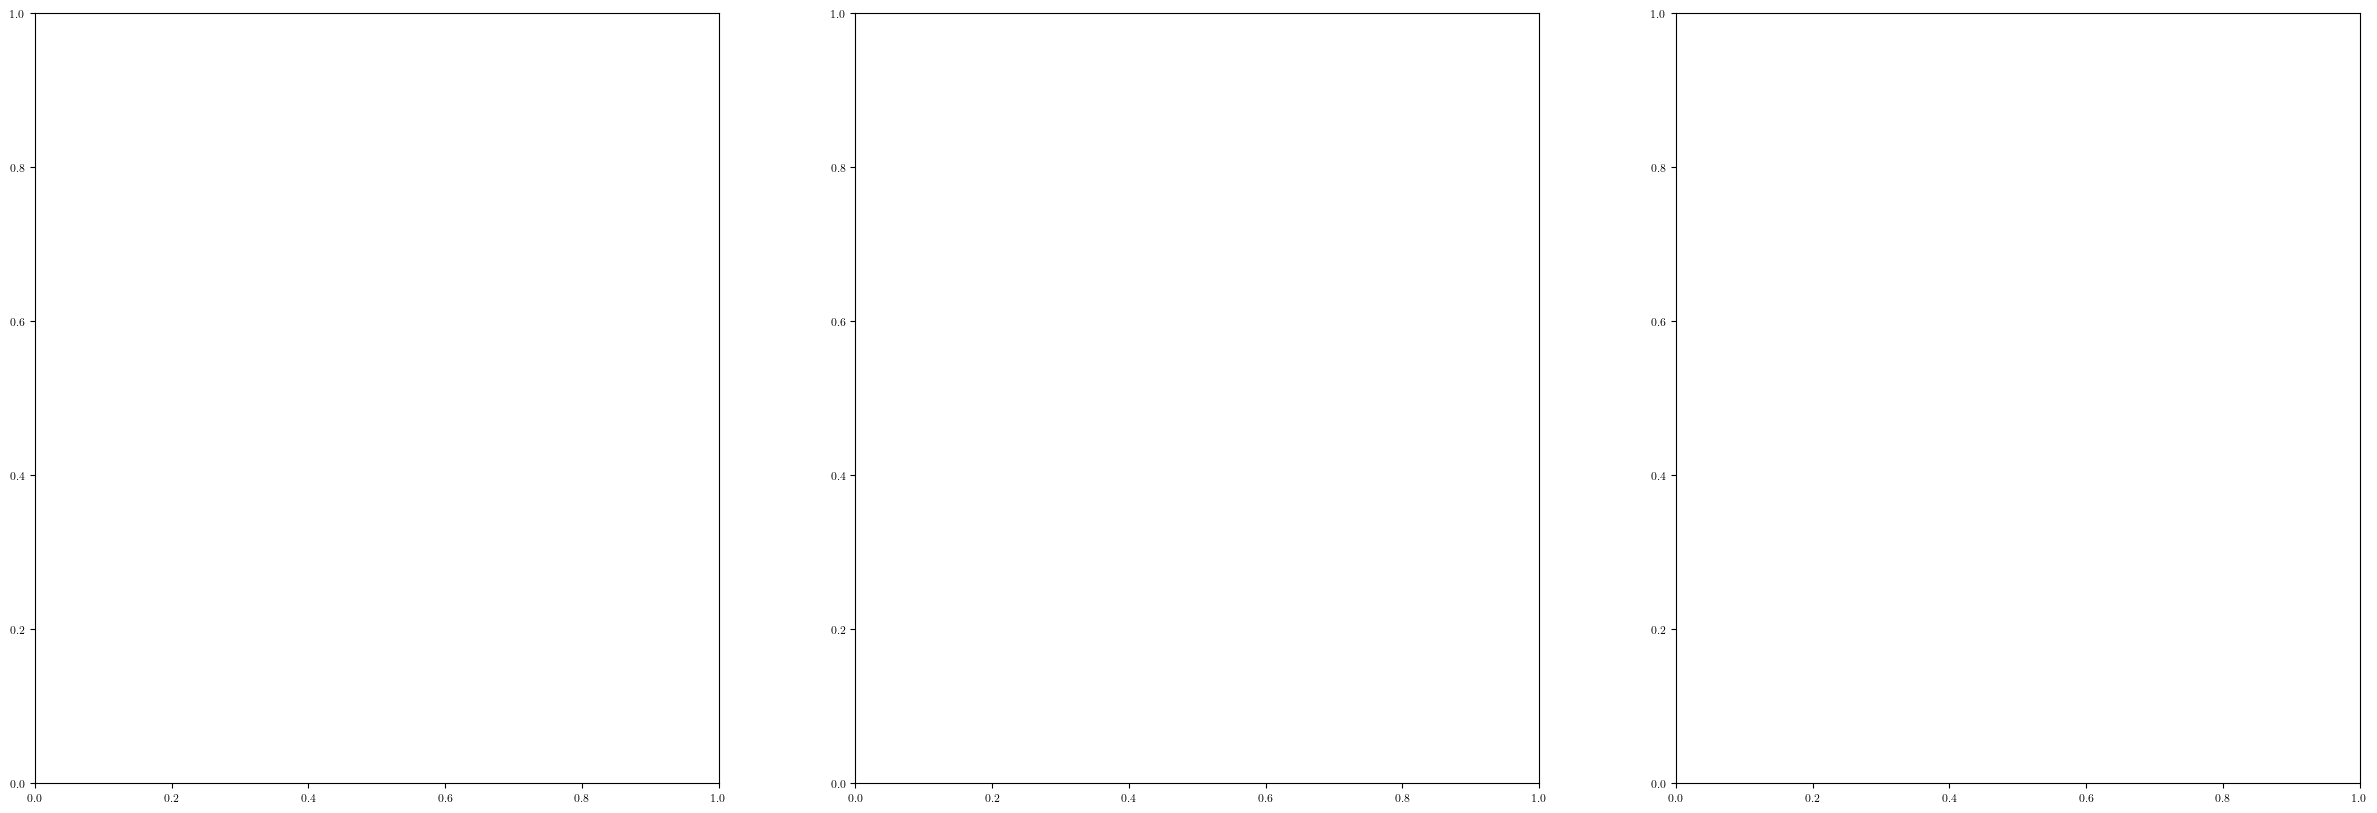

In [6]:
a = [1,2,4,7,10]
fig = plt.figure(figsize=(30,10))
gs = gridspec.GridSpec(1,3)

plot1 = plt.subplot(gs[0,0])
plot2 = plt.subplot(gs[0,1])
plot3 = plt.subplot(gs[0,2])

for i in range(len(a)):
    V1 = np.array([1])
    V2 = np.array([20]*a[i])
    V3 = np.array([1])
    layers = np.hstack([V1, V2, V3])
    model = PhysicsInformedNN(t_data, u_data, layers)
    It, Loss, Lambda_1, Lambda_2 = model.train(30000)
    plot1.plot(It,np.abs(np.array(Lambda_1)-1),label = 'layers=%d'%a[i]) 
    plot2.plot(It,np.abs(np.array(Lambda_2)-3),label = 'layers=%d'%a[i]) 
    plot3.semilogy(It, Loss,label = 'layers=%d'%a[i]) 

plot1.set_xlabel('$iter$',fontsize=25)
plot1.set_ylabel('$|\lambda_1 - \hat{\lambda_1}|$',fontsize=25)
plot1.set_title('Error of the $\lambda_1=1$ as a function of iteration')
plot1.legend(fontsize=25)
plot1.tick_params(labelsize=25)

plot2.set_xlabel('$iter$',fontsize=25)
plot2.set_ylabel('$|\lambda_2 - \hat{\lambda_2}|$',fontsize=25)
plot2.set_title('Error of the $\lambda_2=3$ as a function of iteration')
plot2.legend(fontsize=25)
plot2.tick_params(labelsize=25)

plot3.set_xlabel('$iter$',fontsize=25)
plot3.set_ylabel('Loss function',fontsize=25)
plot3.set_title('The loss function of iteration')
plot3.legend(fontsize=25)
plot3.tick_params(labelsize=25)

plt.savefig("1st_linear_lambda.pdf", format="pdf")
plt.show()

In [7]:
layers = [1, 20, 1]

model = PhysicsInformedNN(t_data, u_data, layers)
model.train(60000)

t = t.reshape(100,1)
u_pred, f_pred = model.predict(t) 

It: 0, Loss: 3.864e+00, Lambda_1: 0.001, Lambda_2: -0.001
It: 100, Loss: 1.213e+00, Lambda_1: 0.124, Lambda_2: -0.024
It: 200, Loss: 8.738e-01, Lambda_1: 0.225, Lambda_2: 0.044
It: 300, Loss: 7.013e-01, Lambda_1: 0.302, Lambda_2: 0.097
It: 400, Loss: 5.840e-01, Lambda_1: 0.367, Lambda_2: 0.139
It: 500, Loss: 4.766e-01, Lambda_1: 0.424, Lambda_2: 0.174
It: 600, Loss: 3.649e-01, Lambda_1: 0.476, Lambda_2: 0.206
It: 700, Loss: 2.526e-01, Lambda_1: 0.524, Lambda_2: 0.234
It: 800, Loss: 1.548e-01, Lambda_1: 0.564, Lambda_2: 0.260
It: 900, Loss: 8.516e-02, Lambda_1: 0.598, Lambda_2: 0.281
It: 1000, Loss: 4.591e-02, Lambda_1: 0.624, Lambda_2: 0.298
It: 1100, Loss: 2.816e-02, Lambda_1: 0.645, Lambda_2: 0.312
It: 1200, Loss: 2.106e-02, Lambda_1: 0.661, Lambda_2: 0.324
It: 1300, Loss: 1.789e-02, Lambda_1: 0.675, Lambda_2: 0.334
It: 1400, Loss: 1.596e-02, Lambda_1: 0.687, Lambda_2: 0.343
It: 1500, Loss: 1.448e-02, Lambda_1: 0.699, Lambda_2: 0.353
It: 1600, Loss: 1.325e-02, Lambda_1: 0.711, Lambda

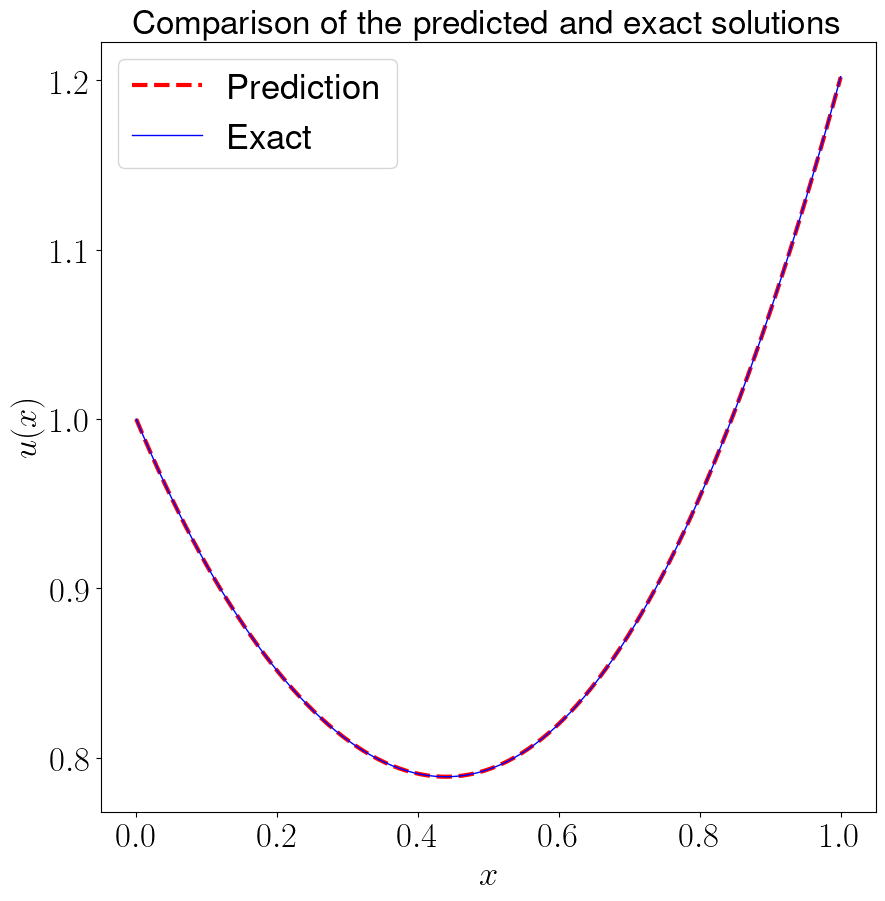

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(t,u_pred,'r--',linewidth = 3, label='Prediction')
ax.plot(t,exat_u,'b-', linewidth = 1, label = 'Exact')
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$u(x)$', fontsize=25)
ax.set_title('Comparison of the predicted and exact solutions')
ax.legend(fontsize=25)
ax.tick_params(labelsize=25)
plt.savefig("1st_linear_prediction.pdf", format="pdf")
plt.show()

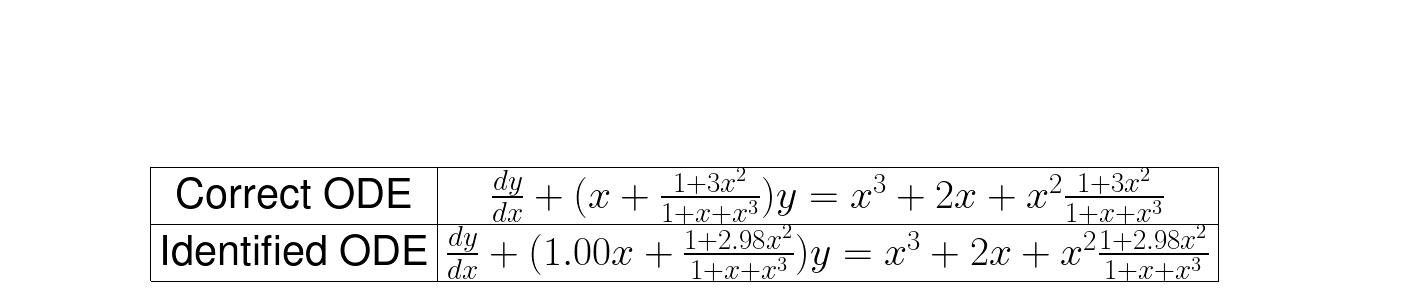

In [9]:
####### Row 3: Identified PDE ##################    
lambda_1_value = model.lambda_1[0]
lambda_2_value = model.lambda_2[0]

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct ODE & $\frac{dy}{dx} + (x+\frac{1+ 3 x^2}{1+x+x^3})y = x^3+2x+x^2\frac{1+ 3 x^2}{1+x+x^3}$ \\  \hline Identified ODE & '
s2 = r'$\frac{dy}{dx} + (%.2f x+\frac{1+ %.2f x^2}{1+x+x^3})y = x^3+2x+x^2\frac{1+ %.2f x^2}{1+x+x^3}$ \\  \hline ' % (lambda_1_value, lambda_2_value, lambda_2_value)
s3 = r'\end{tabular}$'
s = s1+s2+s3
ax.text(0.1, 0.1, s, size=30)

plt.show()